# Vision Transformer (ViT)

In [64]:
from pathlib import Path
import matplotlib.pyplot as plt

IMAGES_PATH = Path() / "pics" / "vit"

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    
    if tight_layout:
        plt.tight_layout()
        
    plt.savefig(path, format=fig_extension, dpi=resolution)

##### Przygotowanie zestawu danych

In [32]:
import random
from typing import Tuple, Optional, Callable
from collections import defaultdict
import PIL

import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.transforms.v2 import Compose, ToImage, ToDtype, Resize, CenterCrop

N_CLASSES = 43

image_preprocessing = Compose([
    ToImage(),
    ToDtype(torch.float32, scale=True),
    Resize(224),
    CenterCrop(224),
])

class GTSRB(Dataset):
    def __init__(self, split: str = "train", gt_only: bool = False, transform: Optional[Callable] = None):
        self.split = split
        self.gt_only = gt_only
        self.samples = []
        self.transform = transform

        self.base_path = f"GTSRB/Final_{'Training' if split == 'train' else 'Test'}/Images"


        if split == "train":
            for i in range(N_CLASSES):
                df = pd.read_csv(f"{self.base_path}/{i}/GT-{i:05d}.csv", sep=";").iloc[:, [0, 7]].to_numpy()
                
                df[:, 0] = f"{i}/" + df[:, 0]

                self.samples.extend(df)
        elif split == "test":
            df = pd.read_csv(f"{self.base_path}/GT-final_test.csv", sep=";").iloc[:, [0, 7]].to_numpy()

            self.samples.extend(df)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index: int) -> tuple:
        path, classId = self.samples[index]

        if self.gt_only:
            return { "label": classId }

        image = PIL.Image.open(f"{self.base_path}/{path}").convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        return { "pixel_values": image, "label": classId }
    
# https://gist.github.com/Alvtron/9b9c2f870df6a54fda24dbd1affdc254
def stratified_train_valid_split(dataset: Dataset, ratio=0.1, random_state=None):
    if random_state is not None:
        random.seed(random_state)

    indices_per_label = defaultdict(list)

    for idx, sample in enumerate(dataset):
        indices_per_label[sample["label"]].append(idx)

    train_indices, valid_indices = [], []

    for label, indices in indices_per_label.items():
        valid_count_in_label = round(len(indices) * ratio)
        valid_indices_sample = random.sample(indices, valid_count_in_label)

        valid_indices.extend(valid_indices_sample)
        train_indices.extend(set(indices) - set(valid_indices_sample))

    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    valid_dataset = torch.utils.data.Subset(dataset, valid_indices)

    return train_dataset, valid_dataset

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

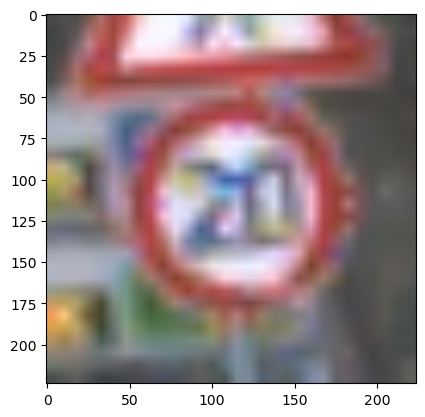

In [42]:
import matplotlib.pyplot as plt

test = GTSRB("train", transform=image_preprocessing)

plt.imshow(test[2]["pixel_values"].permute(1, 2, 0))

##### Model - transformer wizji (ViT)

In [4]:
id2label = {
    0: 'Ograniczenie prędkości (20 km/h)',
    1: 'Ograniczenie prędkości (30 km/h)',
    2: 'Ograniczenie prędkości (50 km/h)',
    3: 'Ograniczenie prędkości (60 km/h)',
    4: 'Ograniczenie prędkości (70 km/h)',
    5: 'Ograniczenie prędkości (80 km/h)',
    6: 'Koniec ograniczenia prędkości (80 km/h)',
    7: 'Ograniczenie prędkości (100 km/h)',
    8: 'Ograniczenie prędkości (120 km/h)',
    9: 'Zakaz wyprzedzania',
    10: 'Zakaz wyprzedzania przez samochody ciężarowe',
    11: 'Skrzyżowanie z drogą podporządkowaną występującą po obu stronach',
    12: 'Droga z pierwszeństwem',
    13: 'Ustąp pierwszeństwa',
    14: 'Bezwzględny nakaz zatrzymania się (stop)',
    15: 'Zakaż ruchu w obu kierunkach',
    16: 'Zakaz wjazdu pojazdów ciężarowych',
    17: 'Zakaz wjazdu',
    18: 'Inne niebezpieczeństwa',
    19: 'Niebezpieczny zakręt w lewo',
    20: 'Niebezpieczny zakręt w prawo',
    21: 'Dwa niebezpieczne zakręty, pierwszy w lewo',
    22: 'Nierówna droga',
    23: 'Śliska jezdnia',
    24: 'Zwężenie jezdni prawostronne',
    25: 'Roboty na drodze',
    26: 'Sygnały świetlne',
    27: 'Piesi',
    28: 'Dzieci',
    29: 'Rowerzyści',
    30: 'Oszronienie jezdni',
    31: 'Zwierzęta dzikie',
    32: 'Koniec zakazów',
    33: 'Nakaz skrętu w prawo za znakiem',
    34: 'Nakaz skrętu w lewo za znakiem',
    35: 'Nakaz jazdy na wprost',
    36: 'Nakaz jazdy prosto lub skrętu w prawo',
    37: 'Nakaz jazdy prosto lub skrętu w lewo',
    38: 'Nakaz jazdy z prawej strony znaku',
    39: 'Nakaż jazdy z lewej strony znaku',
    40: 'Ruch okrężny',
    41: 'Koniec zakazu wyprzedzania',
    42: 'Koniec zakazu wyprzedzania przez samochody ciężarowe',
}

In [5]:
from transformers import ViTImageProcessor, ViTForImageClassification
from torchvision.transforms.v2 import Normalize

model_name = "google/vit-base-patch16-224-in21k"

processor = ViTImageProcessor.from_pretrained(model_name, do_resize=False, return_tensors="pt")

image_preprocessing_normal = Compose([
    image_preprocessing,
    Normalize(mean=processor.image_mean, std=processor.image_std)
])

2024-08-27 14:14:37.607839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 14:14:37.676004: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 14:14:37.696188: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-27 14:14:37.799268: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-27 14:14:39.478287: W tensorflow/compiler/tf2

In [5]:
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=N_CLASSES,
    id2label=id2label,
    label2id={label: id for id, label in id2label.items()}
)

model.to(device)

2024-08-23 18:43:27.326378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-23 18:43:27.343268: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-23 18:43:27.348168: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-23 18:43:27.360376: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-23 18:43:28.196154: W tensorflow/compiler/tf2

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [6]:
def collate(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }


In [7]:
train_set, val_set = stratified_train_valid_split(GTSRB("train", image_preprocessing_normal), random_state=42)

In [8]:
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer

metric = evaluate.load("accuracy")

def calculate_metrics(results):
    return metric.compute(predictions=np.argmax(results.predictions, axis=1), references=results.label_ids)

training_args = TrainingArguments(
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=2,
    output_dir="vit-google-base_gtsrb"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=val_set,
    compute_metrics=calculate_metrics,
    data_collator=collate,
    tokenizer=processor
)

In [9]:
train_results = trainer.train()

  0%|          | 0/5515 [00:00<?, ?it/s]

{'loss': 2.0869, 'grad_norm': 1.7204893827438354, 'learning_rate': 1.818676337262013e-05, 'epoch': 0.45}
{'loss': 0.6631, 'grad_norm': 1.1041667461395264, 'learning_rate': 1.6373526745240257e-05, 'epoch': 0.91}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 0.34356752038002014, 'eval_accuracy': 0.9969395562356542, 'eval_runtime': 65.9852, 'eval_samples_per_second': 59.422, 'eval_steps_per_second': 1.864, 'epoch': 1.0}
{'loss': 0.2819, 'grad_norm': 0.7213943600654602, 'learning_rate': 1.4560290117860384e-05, 'epoch': 1.36}
{'loss': 0.1592, 'grad_norm': 0.2844514548778534, 'learning_rate': 1.2747053490480508e-05, 'epoch': 1.81}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 0.10752160847187042, 'eval_accuracy': 0.9994899260392757, 'eval_runtime': 66.0739, 'eval_samples_per_second': 59.343, 'eval_steps_per_second': 1.862, 'epoch': 2.0}
{'loss': 0.102, 'grad_norm': 0.18557316064834595, 'learning_rate': 1.0933816863100634e-05, 'epoch': 2.27}
{'loss': 0.0737, 'grad_norm': 0.15573181211948395, 'learning_rate': 9.120580235720762e-06, 'epoch': 2.72}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 0.055810581892728806, 'eval_accuracy': 0.9997449630196379, 'eval_runtime': 65.8055, 'eval_samples_per_second': 59.585, 'eval_steps_per_second': 1.869, 'epoch': 3.0}
{'loss': 0.0566, 'grad_norm': 0.11161539703607559, 'learning_rate': 7.3073436083408885e-06, 'epoch': 3.17}
{'loss': 0.0456, 'grad_norm': 0.0979059487581253, 'learning_rate': 5.494106980961016e-06, 'epoch': 3.63}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 0.03817320242524147, 'eval_accuracy': 0.9997449630196379, 'eval_runtime': 68.173, 'eval_samples_per_second': 57.515, 'eval_steps_per_second': 1.804, 'epoch': 4.0}
{'loss': 0.0387, 'grad_norm': 0.13255296647548676, 'learning_rate': 3.6808703535811422e-06, 'epoch': 4.08}
{'loss': 0.0343, 'grad_norm': 0.06816667318344116, 'learning_rate': 1.8676337262012695e-06, 'epoch': 4.53}
{'loss': 0.032, 'grad_norm': 0.06406693160533905, 'learning_rate': 5.43970988213962e-08, 'epoch': 4.99}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 0.03310583159327507, 'eval_accuracy': 0.9997449630196379, 'eval_runtime': 65.992, 'eval_samples_per_second': 59.416, 'eval_steps_per_second': 1.864, 'epoch': 5.0}
{'train_runtime': 7750.5178, 'train_samples_per_second': 22.765, 'train_steps_per_second': 0.712, 'train_loss': 0.32411468048476133, 'epoch': 5.0}


In [13]:
trainer.save_model("vit-google-base_gtsrb_2")

In [14]:
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)

***** train metrics *****
  epoch                    =           5.0
  total_flos               = 12738360976GF
  train_loss               =        0.3241
  train_runtime            =    2:09:10.51
  train_samples_per_second =        22.765
  train_steps_per_second   =         0.712


In [15]:
metrics = trainer.evaluate(GTSRB("test", image_preprocessing_normal))

trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

  0%|          | 0/395 [00:00<?, ?it/s]

***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =     0.9892
  eval_loss               =     0.0747
  eval_runtime            = 0:03:34.58
  eval_samples_per_second =     58.858
  eval_steps_per_second   =      1.841


##### Uczenie od zera

In [8]:
from transformers import ViTConfig, ViTForImageClassification

configuration = ViTConfig.from_pretrained(model_name, num_labels=N_CLASSES, id2label=id2label, label2id={label: id for id, label in id2label.items()})

model = ViTForImageClassification(configuration)

model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [9]:
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

metric = evaluate.load("accuracy")

def calculate_metrics(results):
    return metric.compute(predictions=np.argmax(results.predictions, axis=1), references=results.label_ids)

training_args = TrainingArguments(
    num_train_epochs=30,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=1e-4,
    weight_decay=0.0005,
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=2,
    output_dir="vit-from-ground-up_gtsrb",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=val_set,
    compute_metrics=calculate_metrics,
    data_collator=collate,
    tokenizer=processor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [10]:
train_results = trainer.train()

  0%|          | 0/33090 [00:00<?, ?it/s]

{'loss': 3.0284, 'grad_norm': 8.655783653259277, 'learning_rate': 9.848896947718345e-05, 'epoch': 0.45}
{'loss': 1.891, 'grad_norm': 8.249669075012207, 'learning_rate': 9.697793895436688e-05, 'epoch': 0.91}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 1.518013834953308, 'eval_accuracy': 0.5087987758224942, 'eval_runtime': 64.5483, 'eval_samples_per_second': 60.745, 'eval_steps_per_second': 1.906, 'epoch': 1.0}
{'loss': 1.2401, 'grad_norm': 9.177547454833984, 'learning_rate': 9.546690843155032e-05, 'epoch': 1.36}
{'loss': 0.7438, 'grad_norm': 13.343820571899414, 'learning_rate': 9.395587790873376e-05, 'epoch': 1.81}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 0.5461913347244263, 'eval_accuracy': 0.8309104820198929, 'eval_runtime': 64.9828, 'eval_samples_per_second': 60.339, 'eval_steps_per_second': 1.893, 'epoch': 2.0}
{'loss': 0.5011, 'grad_norm': 4.767239570617676, 'learning_rate': 9.24448473859172e-05, 'epoch': 2.27}
{'loss': 0.4055, 'grad_norm': 8.296747207641602, 'learning_rate': 9.093381686310064e-05, 'epoch': 2.72}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 0.3316941559314728, 'eval_accuracy': 0.8890589135424637, 'eval_runtime': 65.4845, 'eval_samples_per_second': 59.877, 'eval_steps_per_second': 1.878, 'epoch': 3.0}
{'loss': 0.3232, 'grad_norm': 12.506760597229004, 'learning_rate': 8.942278634028408e-05, 'epoch': 3.17}
{'loss': 0.2953, 'grad_norm': 6.616726875305176, 'learning_rate': 8.791175581746751e-05, 'epoch': 3.63}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 0.3639637231826782, 'eval_accuracy': 0.8908441724049987, 'eval_runtime': 65.1816, 'eval_samples_per_second': 60.155, 'eval_steps_per_second': 1.887, 'epoch': 4.0}
{'loss': 0.2385, 'grad_norm': 6.518585205078125, 'learning_rate': 8.640072529465096e-05, 'epoch': 4.08}
{'loss': 0.205, 'grad_norm': 2.61513614654541, 'learning_rate': 8.488969477183439e-05, 'epoch': 4.53}
{'loss': 0.2062, 'grad_norm': 2.737314462661743, 'learning_rate': 8.337866424901784e-05, 'epoch': 4.99}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 0.3294334411621094, 'eval_accuracy': 0.9033409844427442, 'eval_runtime': 66.8575, 'eval_samples_per_second': 58.647, 'eval_steps_per_second': 1.84, 'epoch': 5.0}
{'loss': 0.1764, 'grad_norm': 1.305323839187622, 'learning_rate': 8.186763372620127e-05, 'epoch': 5.44}
{'loss': 0.1522, 'grad_norm': 12.062885284423828, 'learning_rate': 8.035660320338472e-05, 'epoch': 5.89}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 0.25889796018600464, 'eval_accuracy': 0.9250191277735271, 'eval_runtime': 64.9856, 'eval_samples_per_second': 60.336, 'eval_steps_per_second': 1.893, 'epoch': 6.0}
{'loss': 0.1359, 'grad_norm': 5.396873474121094, 'learning_rate': 7.884557268056815e-05, 'epoch': 6.35}
{'loss': 0.1321, 'grad_norm': 3.748814105987549, 'learning_rate': 7.733454215775158e-05, 'epoch': 6.8}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 0.15383566915988922, 'eval_accuracy': 0.9543483805151747, 'eval_runtime': 64.6455, 'eval_samples_per_second': 60.654, 'eval_steps_per_second': 1.903, 'epoch': 7.0}
{'loss': 0.1193, 'grad_norm': 12.171283721923828, 'learning_rate': 7.582351163493503e-05, 'epoch': 7.25}
{'loss': 0.1022, 'grad_norm': 3.411762237548828, 'learning_rate': 7.431248111211848e-05, 'epoch': 7.71}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 0.1521381139755249, 'eval_accuracy': 0.9535832695740882, 'eval_runtime': 65.2104, 'eval_samples_per_second': 60.128, 'eval_steps_per_second': 1.886, 'epoch': 8.0}
{'loss': 0.0968, 'grad_norm': 9.516056060791016, 'learning_rate': 7.280145058930191e-05, 'epoch': 8.16}
{'loss': 0.0902, 'grad_norm': 10.204944610595703, 'learning_rate': 7.129042006648534e-05, 'epoch': 8.61}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 0.14123386144638062, 'eval_accuracy': 0.9571537872991583, 'eval_runtime': 64.9205, 'eval_samples_per_second': 60.397, 'eval_steps_per_second': 1.895, 'epoch': 9.0}
{'loss': 0.0872, 'grad_norm': 0.749151885509491, 'learning_rate': 6.977938954366878e-05, 'epoch': 9.07}
{'loss': 0.0679, 'grad_norm': 6.782794952392578, 'learning_rate': 6.826835902085222e-05, 'epoch': 9.52}
{'loss': 0.072, 'grad_norm': 0.1615973860025406, 'learning_rate': 6.675732849803567e-05, 'epoch': 9.97}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 0.09599950164556503, 'eval_accuracy': 0.9696505993369039, 'eval_runtime': 65.5321, 'eval_samples_per_second': 59.833, 'eval_steps_per_second': 1.877, 'epoch': 10.0}
{'loss': 0.0644, 'grad_norm': 4.114171981811523, 'learning_rate': 6.52462979752191e-05, 'epoch': 10.43}
{'loss': 0.0591, 'grad_norm': 6.175189971923828, 'learning_rate': 6.373526745240254e-05, 'epoch': 10.88}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 0.0907822847366333, 'eval_accuracy': 0.9739862280030605, 'eval_runtime': 65.1813, 'eval_samples_per_second': 60.155, 'eval_steps_per_second': 1.887, 'epoch': 11.0}
{'loss': 0.044, 'grad_norm': 0.09762515872716904, 'learning_rate': 6.222423692958598e-05, 'epoch': 11.33}
{'loss': 0.0554, 'grad_norm': 4.911643028259277, 'learning_rate': 6.0713206406769416e-05, 'epoch': 11.79}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 0.09967458993196487, 'eval_accuracy': 0.969905636317266, 'eval_runtime': 65.4125, 'eval_samples_per_second': 59.943, 'eval_steps_per_second': 1.88, 'epoch': 12.0}
{'loss': 0.0461, 'grad_norm': 0.20513659715652466, 'learning_rate': 5.920217588395286e-05, 'epoch': 12.24}
{'loss': 0.0441, 'grad_norm': 1.546129822731018, 'learning_rate': 5.76911453611363e-05, 'epoch': 12.69}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 0.08277547359466553, 'eval_accuracy': 0.9770466717674062, 'eval_runtime': 65.78, 'eval_samples_per_second': 59.608, 'eval_steps_per_second': 1.87, 'epoch': 13.0}
{'loss': 0.0358, 'grad_norm': 0.026669492945075035, 'learning_rate': 5.618011483831974e-05, 'epoch': 13.15}
{'loss': 0.0266, 'grad_norm': 0.20433789491653442, 'learning_rate': 5.466908431550317e-05, 'epoch': 13.6}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 0.10460734367370605, 'eval_accuracy': 0.9724560061208876, 'eval_runtime': 64.788, 'eval_samples_per_second': 60.52, 'eval_steps_per_second': 1.898, 'epoch': 14.0}
{'loss': 0.0416, 'grad_norm': 1.275485634803772, 'learning_rate': 5.3158053792686615e-05, 'epoch': 14.05}
{'loss': 0.0218, 'grad_norm': 2.5257508754730225, 'learning_rate': 5.1647023269870055e-05, 'epoch': 14.51}
{'loss': 0.0229, 'grad_norm': 0.3655230402946472, 'learning_rate': 5.0135992747053495e-05, 'epoch': 14.96}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 0.07725115865468979, 'eval_accuracy': 0.97985207855139, 'eval_runtime': 65.5097, 'eval_samples_per_second': 59.854, 'eval_steps_per_second': 1.878, 'epoch': 15.0}
{'loss': 0.0237, 'grad_norm': 0.23942942917346954, 'learning_rate': 4.862496222423693e-05, 'epoch': 15.41}
{'loss': 0.0211, 'grad_norm': 0.10050017386674881, 'learning_rate': 4.7113931701420375e-05, 'epoch': 15.87}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 0.10709413886070251, 'eval_accuracy': 0.9739862280030605, 'eval_runtime': 65.2185, 'eval_samples_per_second': 60.121, 'eval_steps_per_second': 1.886, 'epoch': 16.0}
{'loss': 0.0224, 'grad_norm': 0.018762415274977684, 'learning_rate': 4.560290117860381e-05, 'epoch': 16.32}
{'loss': 0.0184, 'grad_norm': 13.849306106567383, 'learning_rate': 4.409187065578725e-05, 'epoch': 16.77}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 0.08981995284557343, 'eval_accuracy': 0.9811272634532007, 'eval_runtime': 64.3676, 'eval_samples_per_second': 60.916, 'eval_steps_per_second': 1.911, 'epoch': 17.0}
{'loss': 0.0137, 'grad_norm': 8.765095710754395, 'learning_rate': 4.258084013297069e-05, 'epoch': 17.23}
{'loss': 0.0128, 'grad_norm': 0.015873659402132034, 'learning_rate': 4.106980961015413e-05, 'epoch': 17.68}


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 0.103770911693573, 'eval_accuracy': 0.9770466717674062, 'eval_runtime': 65.0706, 'eval_samples_per_second': 60.258, 'eval_steps_per_second': 1.89, 'epoch': 18.0}
{'train_runtime': 27698.1113, 'train_samples_per_second': 38.221, 'train_steps_per_second': 1.195, 'train_loss': 0.27440247442518895, 'epoch': 18.0}


In [13]:
trainer.save_model("vit-from-ground-up_gtsrb")

In [14]:
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)

***** train metrics *****
  epoch                    =          18.0
  total_flos               = 45858099517GF
  train_loss               =        0.2744
  train_runtime            =    7:41:38.11
  train_samples_per_second =        38.221
  train_steps_per_second   =         1.195


In [15]:
metrics = trainer.evaluate(GTSRB("test", image_preprocessing_normal))

trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

  0%|          | 0/395 [00:00<?, ?it/s]

***** eval metrics *****
  epoch                   =       18.0
  eval_accuracy           =     0.9127
  eval_loss               =     0.4671
  eval_runtime            = 0:03:35.12
  eval_samples_per_second =      58.71
  eval_steps_per_second   =      1.836


In [25]:
from transformers import ViTImageProcessor, ViTForImageClassification
from torchvision.transforms.v2 import Compose, Normalize

model_name = "vit-from-ground-up_gtsrb"

processor = ViTImageProcessor.from_pretrained(model_name, do_resize=False, return_tensors="pt")

image_preprocessing = Compose([
    ToImage(),
    Resize(224),
    CenterCrop(224),
])

image_preprocessing_normal = Compose([
    ToImage(),
    ToDtype(torch.float32, scale=True),
    Resize(224),
    CenterCrop(224),
    Normalize(mean=processor.image_mean, std=processor.image_std)
])


model = ViTForImageClassification.from_pretrained(model_name, attn_implementation="eager")
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [44]:
from transformers import Trainer

trainer = Trainer(model, None, tokenizer=processor)

In [48]:
y_pred = trainer.predict(GTSRB("test", transform=image_preprocessing_normal))

In [51]:
y_pred_single = np.argmax(y_pred.predictions, axis=1)

In [53]:
y_gt = np.array([sample["label"] for sample in GTSRB("test", gt_only=True)])

In [63]:
from sklearn.metrics import confusion_matrix

confm = confusion_matrix(y_gt, y_pred_single, normalize="pred").round(2)

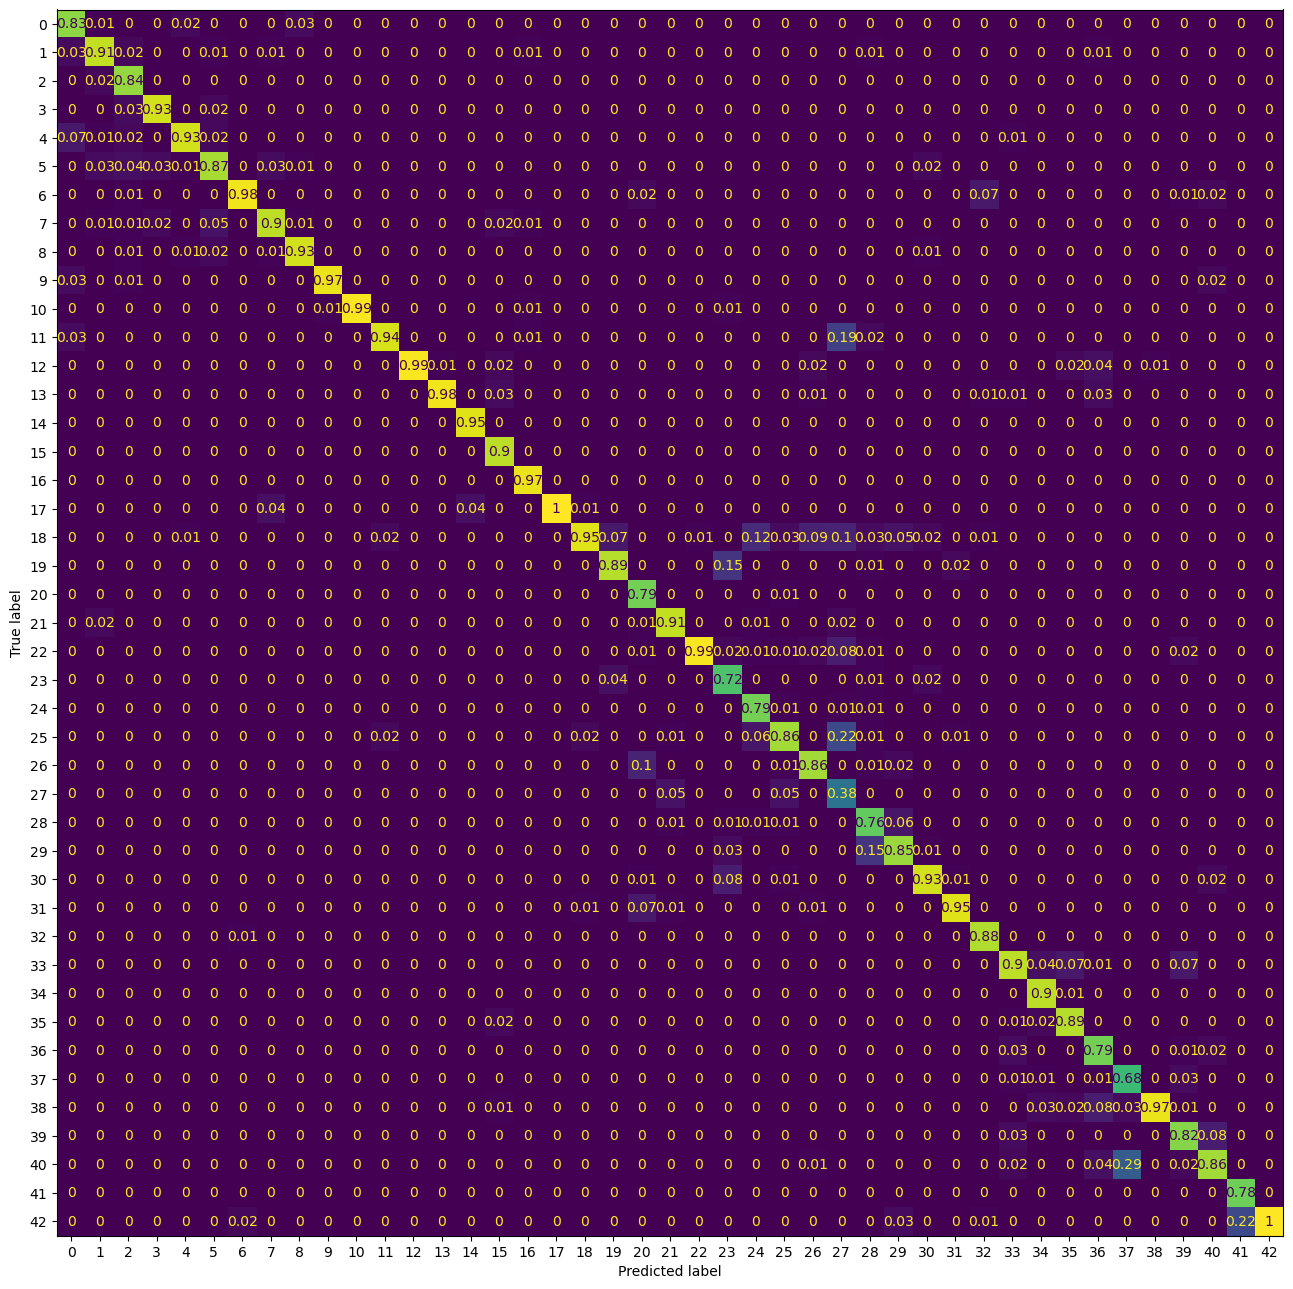

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(13, 13))

cmd = ConfusionMatrixDisplay(confusion_matrix=confm, display_labels=range(43))
cmd.plot(ax=ax, colorbar=False)

save_fig("confusion_matrix_gu")
plt.show()

##### Wizualizacja działania

In [13]:
from transformers import ViTImageProcessor, ViTForImageClassification
from torchvision.transforms.v2 import Compose, Normalize

model_name = "vit-google-base_gtsrb_2"

processor = ViTImageProcessor.from_pretrained(model_name, do_resize=False, return_tensors="pt")

image_preprocessing = Compose([
    ToImage(),
    Resize(224),
    CenterCrop(224),
])

image_preprocessing_normal = Compose([
    ToImage(),
    ToDtype(torch.float32, scale=True),
    Resize(224),
    CenterCrop(224),
    Normalize(mean=processor.image_mean, std=processor.image_std)
])


model = ViTForImageClassification.from_pretrained(model_name, attn_implementation="eager")

2024-09-02 19:59:29.265809: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
samples = GTSRB("test", image_preprocessing)
samples_preprocessed = GTSRB("test", image_preprocessing_normal)

In [43]:
import matplotlib.pyplot as plt

plt.imshow(samples.__getitem__(0)['pixel_values'].numpy().transpose(1, 2, 0))

NameError: name 'samples' is not defined

In [ ]:
model(samples_preprocessed.__getitem__(0)['pixel_values'].unsqueeze(0), output_attentions=True).logits

tensor([[-4.1743e-04, -3.0224e-01, -1.6911e-01, -2.1320e-01, -3.2939e-01,
         -2.0388e-02, -3.6121e-02,  1.4602e-01, -1.5320e-01, -8.8329e-02,
          3.2817e-01, -5.1049e-01, -2.8998e-01, -3.8044e-03, -1.7153e-01,
         -1.0866e-01,  6.2982e+00, -2.3832e-01, -5.9062e-01,  6.7480e-02,
         -4.6086e-02, -1.1251e-01, -2.4926e-01, -1.1193e-01, -4.4897e-02,
         -2.4268e-01, -2.1313e-01, -1.9128e-01, -3.1936e-01, -2.7288e-01,
         -1.0205e-01, -3.8094e-01,  4.8051e-02, -9.0042e-02, -4.3145e-01,
         -2.3514e-01, -6.4183e-02, -3.6605e-01,  1.4871e-01, -2.8718e-01,
         -1.1923e-01, -2.2649e-01, -1.3810e-01]], grad_fn=<AddmmBackward0>)

In [12]:
import cv2
import torch
import numpy as np

# https://github.com/jeonsworld/ViT-pytorch/blob/main/visualize_attention_map.ipynb
def attention_map(model, preprocessed_image, original_image):
    output = model(preprocessed_image.unsqueeze(0), output_attentions=True)

    logits = output.logits
    attentions = output.attentions

    attentions = torch.stack(attentions).squeeze(1)
    attentions = attentions.mean(dim=1)

    residual_attention = torch.eye(attentions.size(1))
    augmented_attentions = attentions + residual_attention
    augmented_attentions = augmented_attentions / augmented_attentions.sum(dim=-1).unsqueeze(-1)

    joint_attentions = torch.zeros(augmented_attentions.size())
    joint_attentions[0] = augmented_attentions[0]

    for n in range(1, augmented_attentions.size(0)):
        joint_attentions[n] = torch.matmul(augmented_attentions[n], joint_attentions[n - 1])

    v = joint_attentions[-1]
    grid_size = int(np.sqrt(augmented_attentions.size(-1)))

    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    original_image = original_image.permute(1, 2, 0).numpy()

    mask = cv2.resize(mask / mask.max(), original_image.shape[:-1])[..., np.newaxis]

    return (mask * original_image).astype("uint8")

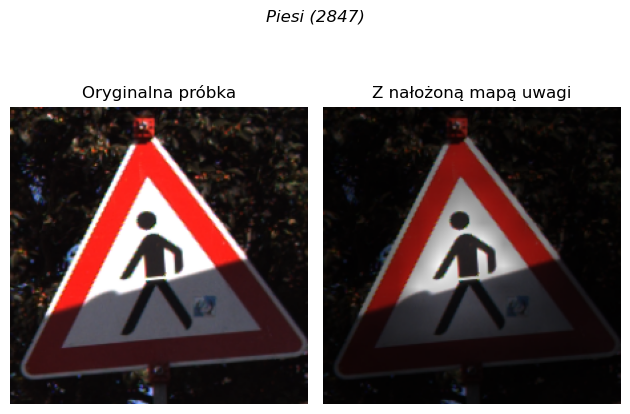

In [ ]:
import matplotlib.pyplot as plt

sample_idx = 2847

preprocessed_sample = samples_preprocessed.__getitem__(sample_idx)['pixel_values']
original_sample = samples.__getitem__(sample_idx)['pixel_values']

mask = attention_map(model, preprocessed_sample, original_sample)

fig, ax = plt.subplots(1, 2)

fig.suptitle(f"{id2label[samples.__getitem__(sample_idx)['label']]} ({sample_idx})", fontstyle="italic")

ax[0].imshow(samples.__getitem__(sample_idx)['pixel_values'].permute(1, 2, 0))
ax[0].set_axis_off()
ax[0].set_title("Oryginalna próbka")

ax[1].imshow(mask)
ax[1].set_axis_off()
ax[1].set_title("Z nałożoną mapą uwagi")

plt.tight_layout()

save_fig(f"attention_map_{sample_idx}", tight_layout=True)